# data/mc plots in 2018

### Post-process Data and MC samples

- Sum all MC samples that belong to the same process
- Scale the number of events by the total sum of weights

In [12]:
# import utilities for post-process
import utils

import vector
import pandas as pd
import numpy as np

In [2]:
samples = {
    "hh4b": ["GluGlutoHHto4B_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8"],
    "hh4b-kl0": ["GluGlutoHHto4B_cHHH0_TuneCP5_PSWeights_13TeV-powheg-pythia8"],
    "hh4b-kl2p45": ["GluGlutoHHto4B_cHHH2p45_TuneCP5_PSWeights_13TeV-powheg-pythia8"],
    "hh4b-kl5": ["GluGlutoHHto4B_cHHH5_TuneCP5_PSWeights_13TeV-powheg-pythia8"],
    "qcd": [
        "QCD_HT-200to300-13TeV",
        "QCD_HT-300to500-13TeV"
        "QCD_HT-500to700-13TeV",
        "QCD_HT-700to1000-13TeV",
        "QCD_HT-1000to1500-13TeV",
        "QCD_HT-1500to2000-13TeV",
        "QCD_HT-2000toInf-13TeV",
    ],
    #"ttbar": [
    #    "TTToSemiLeptonic_13TeV",
    #    "TTToHadronic_13TeV",
    #    "TTTo2L2Nu_13TeV",
    #],
    "vjets": [
        "WJetsToQQ_HT-200to400_13TeV",
        "WJetsToQQ_HT-400to600_13TeV",
        "WJetsToQQ_HT-600to800_13TeV",
        "WJetsToQQ_HT-800toInf_13TeV", 
        "ZJetsToQQ_HT-200to400_13TeV",
        "ZJetsToQQ_HT-400to600_13TeV",
        "ZJetsToQQ_HT-600to800_13TeV",
        "ZJetsToQQ_HT-800toInf_13TeV",
    ],
    "hbb": [
        "GluGluHToBB_Pt-200ToInf_M-125_TuneCP5_MINLO_13TeV-powheg-pythia8",
        "VBFHToBB_M-125_dipoleRecoilOn_TuneCP5_13TeV-powheg-pythia8",
        "WminusH_HToBB_WToQQ_M-125_TuneCP5_13TeV-powheg-pythia8",
        "WminusH_HToBB_WToLNu_M-125_TuneCP5_13TeV-powheg-pythia8",
        "WplusH_HToBB_WToQQ_M-125_TuneCP5_13TeV-powheg-pythia8",
        "WplusH_HToBB_WToLNu_M-125_TuneCP5_13TeV-powheg-pythia8",
        "ZH_HToBB_ZToQQ_M-125_TuneCP5_13TeV-powheg-pythia8",
        "ZH_HToBB_ZToLL_M-125_TuneCP5_13TeV-powheg-pythia8",
        "ZH_HToBB_ZToNuNu_M-125_TuneCP5_13TeV-powheg-pythia8",
        "ggZH_HToBB_ZToBB_M-125_TuneCP5_13TeV-powheg-pythia8",
        "ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8",
    ],
    "diboson": [
        "ZZTo4B01j_5f_TuneCP5_13TeV-amcatnloFXFX-pythia8",
    ]
}

samples_to_use = {s: samples[s] for s in ["qcd","hh4b","hh4b-kl2p45","hh4b-kl5","hh4b-kl0"]}

# define dictionary with directories of files (this can be configured in a yaml file later in the script)
# this is the directory to the files
path_to_dir = "/eos/uscms/store/user/cmantill/bbbb/matching/Oct10"
dirs = {path_to_dir: samples_to_use}
year = "2018"

In [3]:
# filters are sequences of strings that can be used to place a selection or mask in the parquet files
# e.g. https://github.com/rkansal47/HHbbVV/blob/main/src/HHbbVV/postprocessing/postprocessing.py#L80
filters = [
    [
        ("('ak8FatJetPt', '0')", ">=", 300),
        ("('ak8FatJetMsd', '0')", ">=", 60),
        ("('ak8FatJetPNetXbb', '0')", ">=", 0.975),
        ("('ak8FatJetPNetXbb', '1')", "<", 0.975),
    ]
]

In [28]:
# columns to load
# the parquet files are too big so we can only load a few columns at a time without consumming much memory
load_columns = [
    ("weight", 1),
    ("ak4JetPt", 4),
    ("ak4JetPhi", 4),
    ("ak4JetEta", 4),
    ("ak4JetMass", 4),
    ("ak4JetbtagDeepFlavB", 4),
    ("ak4Pair0", 2),
    ("ak4Pair1", 2),
    ("ak8FatJetPt", 2),
    ("ak8FatJetEta", 2),
    ("ak8FatJetPhi", 2),
    ("ak8FatJetPNetMass", 2),
    ("ak8FatJetPNetXbb", 2),
]
# reformat into ("column name", "idx") format for reading multiindex columns
columns = []
for key, num_columns in load_columns:
    for i in range(num_columns):
        columns.append(f"('{key}', '{i}')")

In [57]:
def make_vector(events: pd.DataFrame, obj: str):
    """Create a ``vector`` object from the columns of the dataframe"""
    mstring = "PNetMass" if obj == "ak8FatJet" else "Mass"

    return vector.array(
        {
            "pt": events[f"{obj}Pt"],
            "phi": events[f"{obj}Phi"],
            "eta": events[f"{obj}Eta"],
            "M": events[f"{obj}{mstring}"],
        }
    )

def add_jet_variables(events):
    fatjets = make_vector(events, "ak8FatJet")
    fatjet_0 = fatjets[:, 0]

    jets = make_vector(events, "ak4Jet")
    jets_shape = np.arange(len(jets.pt))

    # get unordered pairs
    first_bb_pair = events.ak4Pair0.to_numpy()
    second_bb_pair = events.ak4Pair1.to_numpy()

    first_bb_j1 = jets[jets_shape, first_bb_pair[:, 0]]
    first_bb_j2 = jets[jets_shape, first_bb_pair[:, 1]]
    first_bb_dijet = first_bb_j1 + first_bb_j2

    second_bb_j1 = jets[jets_shape, second_bb_pair[:, 0]]
    second_bb_j2 = jets[jets_shape, second_bb_pair[:, 1]]
    second_bb_dijet = second_bb_j1 + second_bb_j2

    # stack pairs
    bb_pairs = np.stack([first_bb_pair, second_bb_pair], axis=1)

    # sort by deltaR with leading fatjet
    bbs_dRfj = np.concatenate(
        [first_bb_dijet.deltaR(fatjet_0).reshape(-1, 1), second_bb_dijet.deltaR(fatjet_0).reshape(-1, 1)], axis=1
    )
    # sort from larger dR to smaller
    sort_by_dR = np.argsort(-bbs_dRfj, axis=-1)

    bb_pairs_sorted = np.array(
        [
            [bb_pair_e[sort_e[0]], bb_pair_e[sort_e[1]]]
            for bb_pair_e, sort_e in zip(bb_pairs, sort_by_dR)
        ]
    )

    # get sorted pairs
    first_bb_pair_sort = bb_pairs_sorted[:, 0]
    second_bb_pair_sort = bb_pairs_sorted[:, 1]

    first_bb_j1 = jets[np.arange(len(jets.pt)), first_bb_pair_sort[:, 0]]
    first_bb_j2 = jets[np.arange(len(jets.pt)), first_bb_pair_sort[:, 1]]
    first_bb_dijet = first_bb_j1 + first_bb_j2

    second_bb_j1 = jets[np.arange(len(jets.pt)), second_bb_pair_sort[:, 0]]
    second_bb_j2 = jets[np.arange(len(jets.pt)), second_bb_pair_sort[:, 1]]
    second_bb_dijet = second_bb_j1 + second_bb_j2

    dr_fatjet = first_bb_dijet.deltaR(fatjet_0)

    hh = (first_bb_dijet + fatjet_0)

    events["ak4DijetPt"] = first_bb_dijet.pt
    events["ak4DijetMass"] = first_bb_dijet.mass
    events["ak4DijetdRFatJet"] = dr_fatjet
    events["HHMass"] = hh.mass

    return events

In [58]:
# dictionary that will contain all information (from all samples)
events_dict = {}
for input_dir, samples in dirs.items():
    events_dict = {
        **events_dict,
        # this function will load files (only the columns selected), apply filters and compute a weight per event
        **utils.load_samples(input_dir, samples, year, filters=filters, columns=columns),
    }

Loading QCD_HT-1000to1500-13TeV
/eos/uscms/store/user/cmantill/bbbb/matching/Oct10/2018/QCD_HT-1000to1500-13TeV/parquet
Loading QCD_HT-1500to2000-13TeV
/eos/uscms/store/user/cmantill/bbbb/matching/Oct10/2018/QCD_HT-1500to2000-13TeV/parquet
Loading QCD_HT-2000toInf-13TeV
/eos/uscms/store/user/cmantill/bbbb/matching/Oct10/2018/QCD_HT-2000toInf-13TeV/parquet
Loading QCD_HT-200to300-13TeV
/eos/uscms/store/user/cmantill/bbbb/matching/Oct10/2018/QCD_HT-200to300-13TeV/parquet
Loading QCD_HT-700to1000-13TeV
/eos/uscms/store/user/cmantill/bbbb/matching/Oct10/2018/QCD_HT-700to1000-13TeV/parquet
Loading GluGlutoHHto4B_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8
/eos/uscms/store/user/cmantill/bbbb/matching/Oct10/2018/GluGlutoHHto4B_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8/parquet
Loading GluGlutoHHto4B_cHHH2p45_TuneCP5_PSWeights_13TeV-powheg-pythia8
/eos/uscms/store/user/cmantill/bbbb/matching/Oct10/2018/GluGlutoHHto4B_cHHH2p45_TuneCP5_PSWeights_13TeV-powheg-pythia8/parquet
Loading GluGlutoHH

In [59]:
# add more variables
for sample, events in events_dict.items():
    events_dict[sample] = add_jet_variables(events)

In [44]:
events_dict["hh4b"]

weight    ak4JetPt                                     ak4JetPhi  \
              0           0           1           2           3         0   
0      0.000667  151.578369  145.306824   95.489136   22.472839 -2.461426   
1      0.000667  148.733398  320.261230  200.081543   19.071777  2.438965   
2      0.000667  232.067261  172.029053  260.257324   25.312500  1.756104   
3      0.000667  161.185730  316.538086  474.406006   21.531601 -3.129883   
4      0.000667  115.364441  163.885742  171.742188   12.333973 -1.082764   
...         ...         ...         ...         ...         ...       ...   
23909  0.000667  123.894287  169.014282  232.147583   32.497284 -1.447754   
23910  0.000667  364.772461  337.661133   58.003540  135.057129 -0.043839   
23911  0.000667  111.987305  279.817383  269.986084   61.008911 -2.073730   
23912 -0.000667  278.557617  203.364624  167.651367   21.020264 -0.638062   
23913  0.000667  320.169434  175.328613   72.559204   19.273590  0.393127   

                                    ak4JetEta  ... ak8FatJetPNetMass  \
              1         2         3         0  ...                 0   
0     -2.171875  0.539795  1.516846 -0.079254  ...          137.1250   
1     -0.722046  2.983887  2.107422 -2.060547  ...          132.7500   
2     -1.081787 -1.637695  0.731567 -0.691528  ...          140.1250   
3      2.872070 -0.317749 -1.288818 -0.111084  ...          129.1250   
4      2.257812  1.374756 -1.857910 -0.001912  ...          131.0000   
...         ...       ...       ...       ...  ...               ...   
23909  1.057129 -2.173828 -0.192078 -1.062500  ...          136.8750   
23910  3.127930  0.372498  2.717285  0.857666  ...           99.2500   
23911 -1.770752  0.732178  0.635498 -1.029785  ...          238.8750   
23912  3.000488  2.562500  0.277710  0.164734  ...          138.2500   
23913 -2.631348 -2.924316 -0.596436  0.107040  ...           67.6875   

                 ak8FatJetPNetXbb           weight_nonorm finalWeight  \
               1                0         1                             
0       78.37500         0.997202  0.662519     18.817591    0.000667   
1       36.34375         0.993429  0.557820     18.817591    0.000667   
2      121.81250         0.995235  0.940535     18.817591    0.000667   
3       23.34375         0.996132  0.868056     18.817591    0.000667   
4       50.18750         0.983315  0.546924     18.817591    0.000667   
...          ...              ...       ...           ...         ...   
23909   46.50000         0.989776  0.891656     18.817591    0.000667   
23910   79.68750         0.986279  0.915471     18.817591    0.000667   
23911   22.56250         0.995069  0.298028     18.817591    0.000667   
23912   89.68750         0.993512  0.930439    -18.817591   -0.000667   
23913   78.56250         0.988754  0.889558     18.817591    0.000667   

       ak4DijetPt ak4DijetMass ak4DijetdRFatJet       HHMass  
                                                              
0      109.655588   109.655588         3.067048   432.370730  
1      302.167702   302.167702         2.903577   875.843255  
2      246.169002   246.169002         3.097051   693.720671  
3      486.883348   486.883348         2.993734  1021.793707  
4      303.459660   303.459660         3.446614   890.429935  
...           ...          ...              ...          ...  
23909  181.917539   181.917539         3.147399   669.695852  
23910  418.479108   418.479108         3.100366   932.250549  
23911  330.762525   330.762525         3.288671  1210.328380  
23912  291.839194   291.839194         3.151928   759.441190  
23913  167.589693   167.589693         3.161558   680.081032  

[23914 rows x 41 columns]

In [22]:
# this will be the weight that will be stored in the eventsDict once the utils.loadSamples function is done
weight_key = ["finalWeight"]

In [60]:
samples_loaded = list(events_dict.keys())
keys_loaded = list(events_dict[samples_loaded[0]].keys())
print(f"Keys in events_dict")
print(keys_loaded)

Keys in events_dict
[('weight', 0), ('ak4JetPt', 0), ('ak4JetPt', 1), ('ak4JetPt', 2), ('ak4JetPt', 3), ('ak4JetPhi', 0), ('ak4JetPhi', 1), ('ak4JetPhi', 2), ('ak4JetPhi', 3), ('ak4JetEta', 0), ('ak4JetEta', 1), ('ak4JetEta', 2), ('ak4JetEta', 3), ('ak4JetMass', 0), ('ak4JetMass', 1), ('ak4JetMass', 2), ('ak4JetMass', 3), ('ak4JetbtagDeepFlavB', 0), ('ak4JetbtagDeepFlavB', 1), ('ak4JetbtagDeepFlavB', 2), ('ak4JetbtagDeepFlavB', 3), ('ak4Pair0', 0), ('ak4Pair0', 1), ('ak4Pair1', 0), ('ak4Pair1', 1), ('ak8FatJetPt', 0), ('ak8FatJetPt', 1), ('ak8FatJetEta', 0), ('ak8FatJetEta', 1), ('ak8FatJetPhi', 0), ('ak8FatJetPhi', 1), ('ak8FatJetPNetMass', 0), ('ak8FatJetPNetMass', 1), ('ak8FatJetPNetXbb', 0), ('ak8FatJetPNetXbb', 1), ('weight_nonorm', ''), ('finalWeight', ''), ('ak4DijetPt', ''), ('ak4DijetMass', ''), ('ak4DijetdRFatJet', ''), ('HHMass', '')]


In [24]:
samples_loaded

['qcd', 'hh4b', 'hh4b-kl2p45', 'hh4b-kl5', 'hh4b-kl0']

In [61]:
samples_to_fill = [
    # "data",
    "qcd",
    # "vjets",
    # "ttbar",
    # "hbb",
    # "diboson",
]
vars_to_plot = [
    "ak4DijetPt",
    "ak4DijetMass",
    "ak4DijetdRFatJet",
    # "HHMass",
    "ak8FatJetPt0",
    "ak8FatJetPNetXbb0",
    "ak8FatJetPNetMass0",
]

# define ShapeVar (label and bins for a given variable)
from utils import ShapeVar

var_to_shapevar = {
    # var must match key in events dictionary (i.e. as saved in parquet file)
    "HHMass": ShapeVar(var="HHMass", label=r"AK8 + jj mass (GeV)", bins=[30, 600, 4000]),
    "ak4JetbtagDeepFlavB0": ShapeVar(
        var="ak4JetbtagDeepFlavB0",
        label=r"AK4 deepFlavB $^0$ (GeV)",
        bins=[30, 0, 1],
        significance_dir="right",
    ),
    "ak4JetbtagDeepFlavB1": ShapeVar(
        var="ak4JetbtagDeepFlavB1",
        label=r"AK4 deepFlavB $^1$ (GeV)",
        bins=[30, 0, 1],
        significance_dir="right",
    ),
    "ak4DijetPt": ShapeVar(
        var="ak4DijetPt",
        label=r"AK4 jj $p_T$ (GeV)",
        bins=[30, 300, 1500],
        significance_dir="right",
    ),
    "ak4DijetMass": ShapeVar(
        var="ak4DijetMass", label=r"AK4 jj mass (GeV)", bins=[30, 0, 200], significance_dir="right"
    ),
    "ak4DijetdRFatJet": ShapeVar(
        var="ak4DijetdRFatJet", label=r"AK4 dR(fj)", bins=[30, 0, 5], significance_dir="right"
    ),
    "ak8FatJetPt0": ShapeVar(
        var="ak8FatJetPt0",
        label=r"$AK8 p_T^0$ (GeV)",
        bins=[30, 300, 1500],
        significance_dir="right",
    ),
    "ak8FatJetPNetMass0": ShapeVar(
        var="ak8FatJetPNetMass0", label=r"AK8 $m_{reg}^{0}$ (GeV)", bins=[20, 0, 260]
    ),
    "ak8FatJetPNetXbb0": ShapeVar(
        var="ak8FatJetPNetXbb0",
        label=r"AK8 $TX_{bb}^{0}$",
        bins=[50, 0.8, 1],
    ),
}

In [62]:
# make a histogram
hists = {}
for var in vars_to_plot:
    print(var)
    shape_var = var_to_shapevar[var]
    if shape_var.var not in hists:
        hists[shape_var.var] = utils.singleVarHist(
            events_dict,
            shape_var,
            weight_key=weight_key,
            selection=None,
        )

ak4DijetPt
ak4DijetMass
ak4DijetdRFatJet
ak8FatJetPt0
ak8FatJetPNetXbb0
ak8FatJetPNetMass0


In [63]:
hists

{'ak4DijetPt': Hist(
   StrCategory(['qcd', 'hh4b', 'hh4b-kl2p45', 'hh4b-kl5', 'hh4b-kl0'], name='Sample'),
   Regular(30, 300, 1500, name='ak4DijetPt', label='AK4 jj $p_T$ (GeV)'),
   storage=Weight()) # Sum: WeightedSum(value=164563, variance=1.05829e+06) (WeightedSum(value=668526, variance=4.7377e+06) with flow),
 'ak4DijetMass': Hist(
   StrCategory(['qcd', 'hh4b', 'hh4b-kl2p45', 'hh4b-kl5', 'hh4b-kl0'], name='Sample'),
   Regular(30, 0, 200, name='ak4DijetMass', label='AK4 jj mass (GeV)'),
   storage=Weight()) # Sum: WeightedSum(value=361699, variance=2.62725e+06) (WeightedSum(value=668526, variance=4.7377e+06) with flow),
 'ak4DijetdRFatJet': Hist(
   StrCategory(['qcd', 'hh4b', 'hh4b-kl2p45', 'hh4b-kl5', 'hh4b-kl0'], name='Sample'),
   Regular(30, 0, 5, name='ak4DijetdRFatJet', label='AK4 dR(fj)'),
   storage=Weight()) # Sum: WeightedSum(value=626666, variance=4.43019e+06) (WeightedSum(value=668526, variance=4.7377e+06) with flow),
 'ak8FatJetPt0': Hist(
   StrCategory(['qcd', '

In [64]:
hists["ak4DijetMass"][{"Sample": "hh4b"}]

Hist(Regular(30, 0, 200, name='ak4DijetMass', label='AK4 jj mass (GeV)'), storage=Weight()) # Sum: WeightedSum(value=9.06376, variance=0.00759386) (WeightedSum(value=12.7884, variance=0.0106856) with flow)

[1.52082208e+05 1.68948738e+05 1.27789805e+05 7.98936798e+04
 4.88345369e+04 3.08017235e+04 1.95355814e+04 1.30796156e+04
 8.67076394e+03 5.98795732e+03 3.83926509e+03 2.61500024e+03
 1.82700053e+03 1.29604478e+03 9.13819220e+02 6.35562707e+02
 4.64873674e+02 3.20119687e+02 2.34565130e+02 1.68441512e+02
 1.23586123e+02 1.02868454e+02 7.16629977e+01 5.35030788e+01
 4.25263924e+01 2.85905185e+01 2.65216670e+01 1.63209398e+01
 1.58611950e+01 8.96502326e+00]


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f57225ca8b0>, errorbar=None, legend_artist=None)]

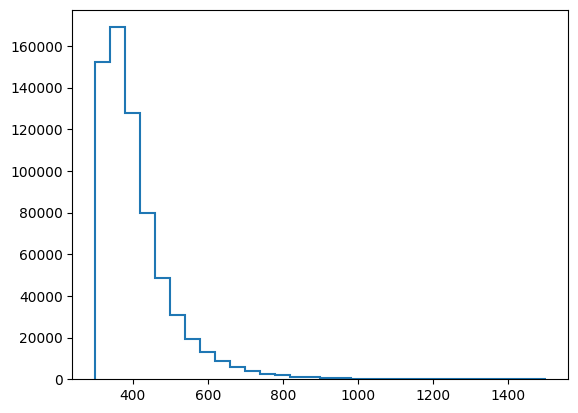

In [51]:
import mplhep as hep

hist, bins = hists["ak8FatJetPt0"][{"Sample": "qcd"}].to_numpy()
print(hist)
hep.histplot(hist, bins=bins, stack=True)

Will plot ak4DijetPt histogram
Will plot ak4DijetMass histogram
Will plot ak4DijetdRFatJet histogram
Will plot ak8FatJetPt0 histogram
Will plot ak8FatJetPNetXbb0 histogram
Will plot ak8FatJetPNetMass0 histogram


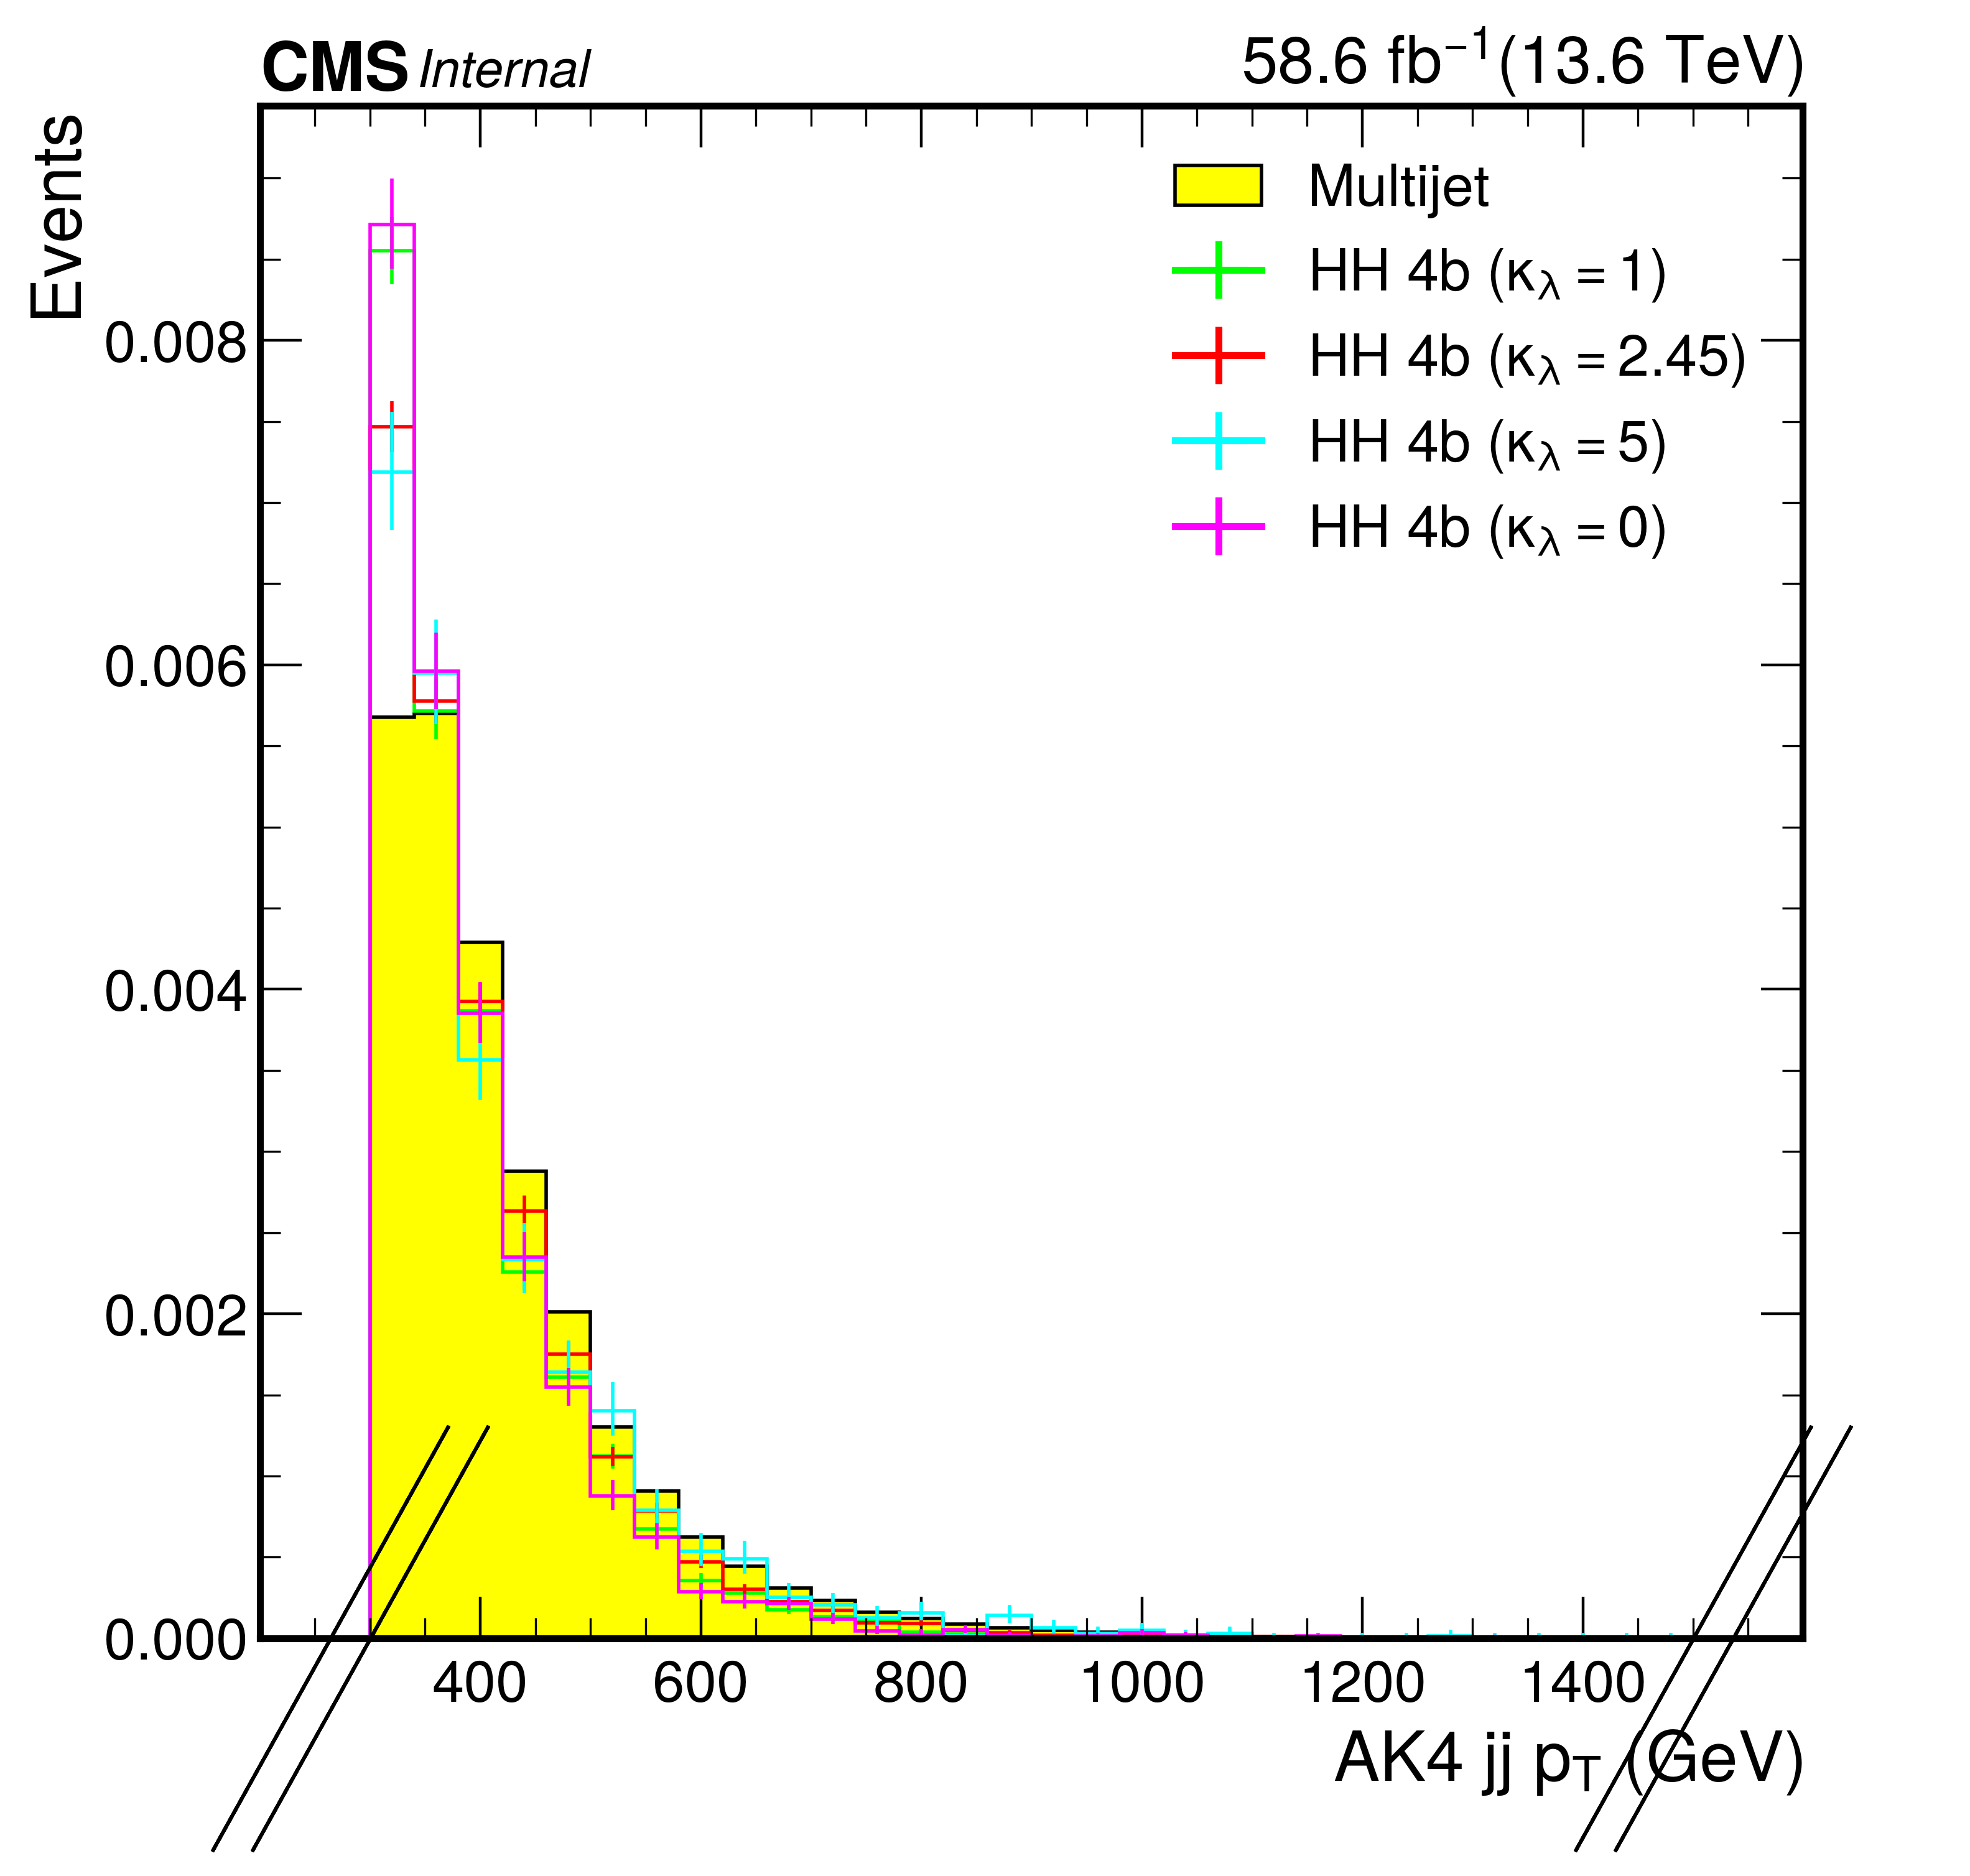

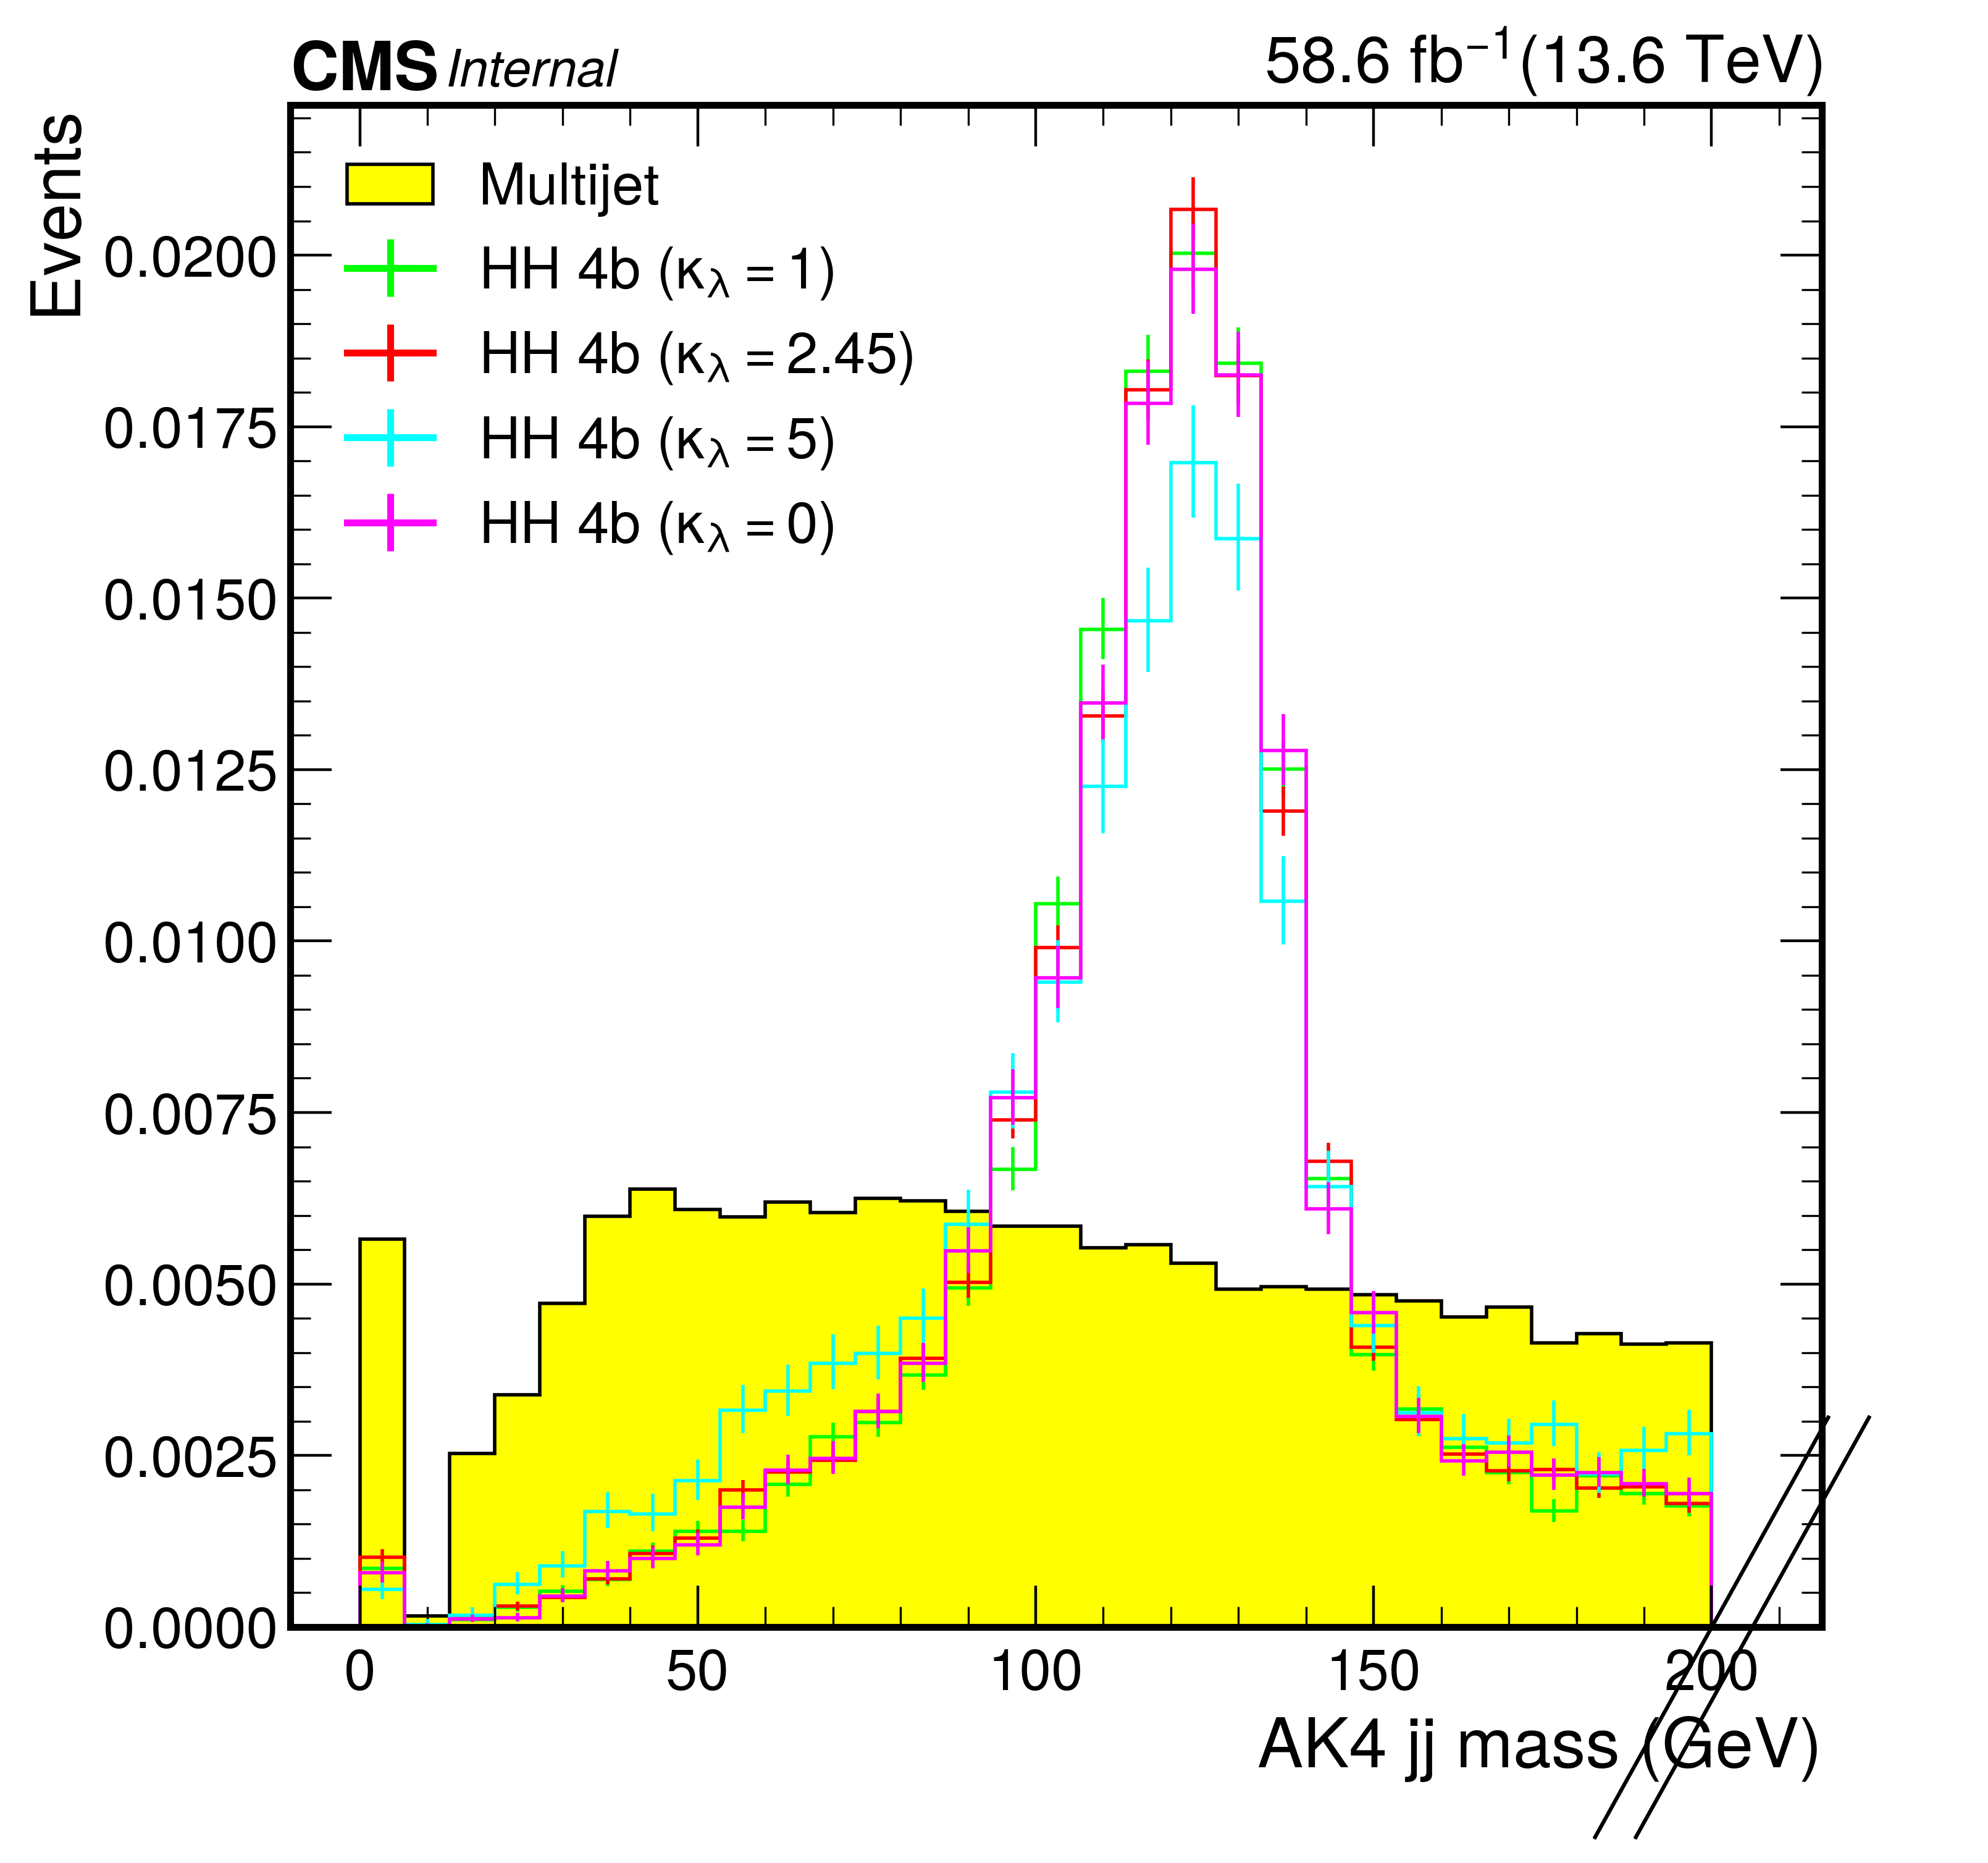

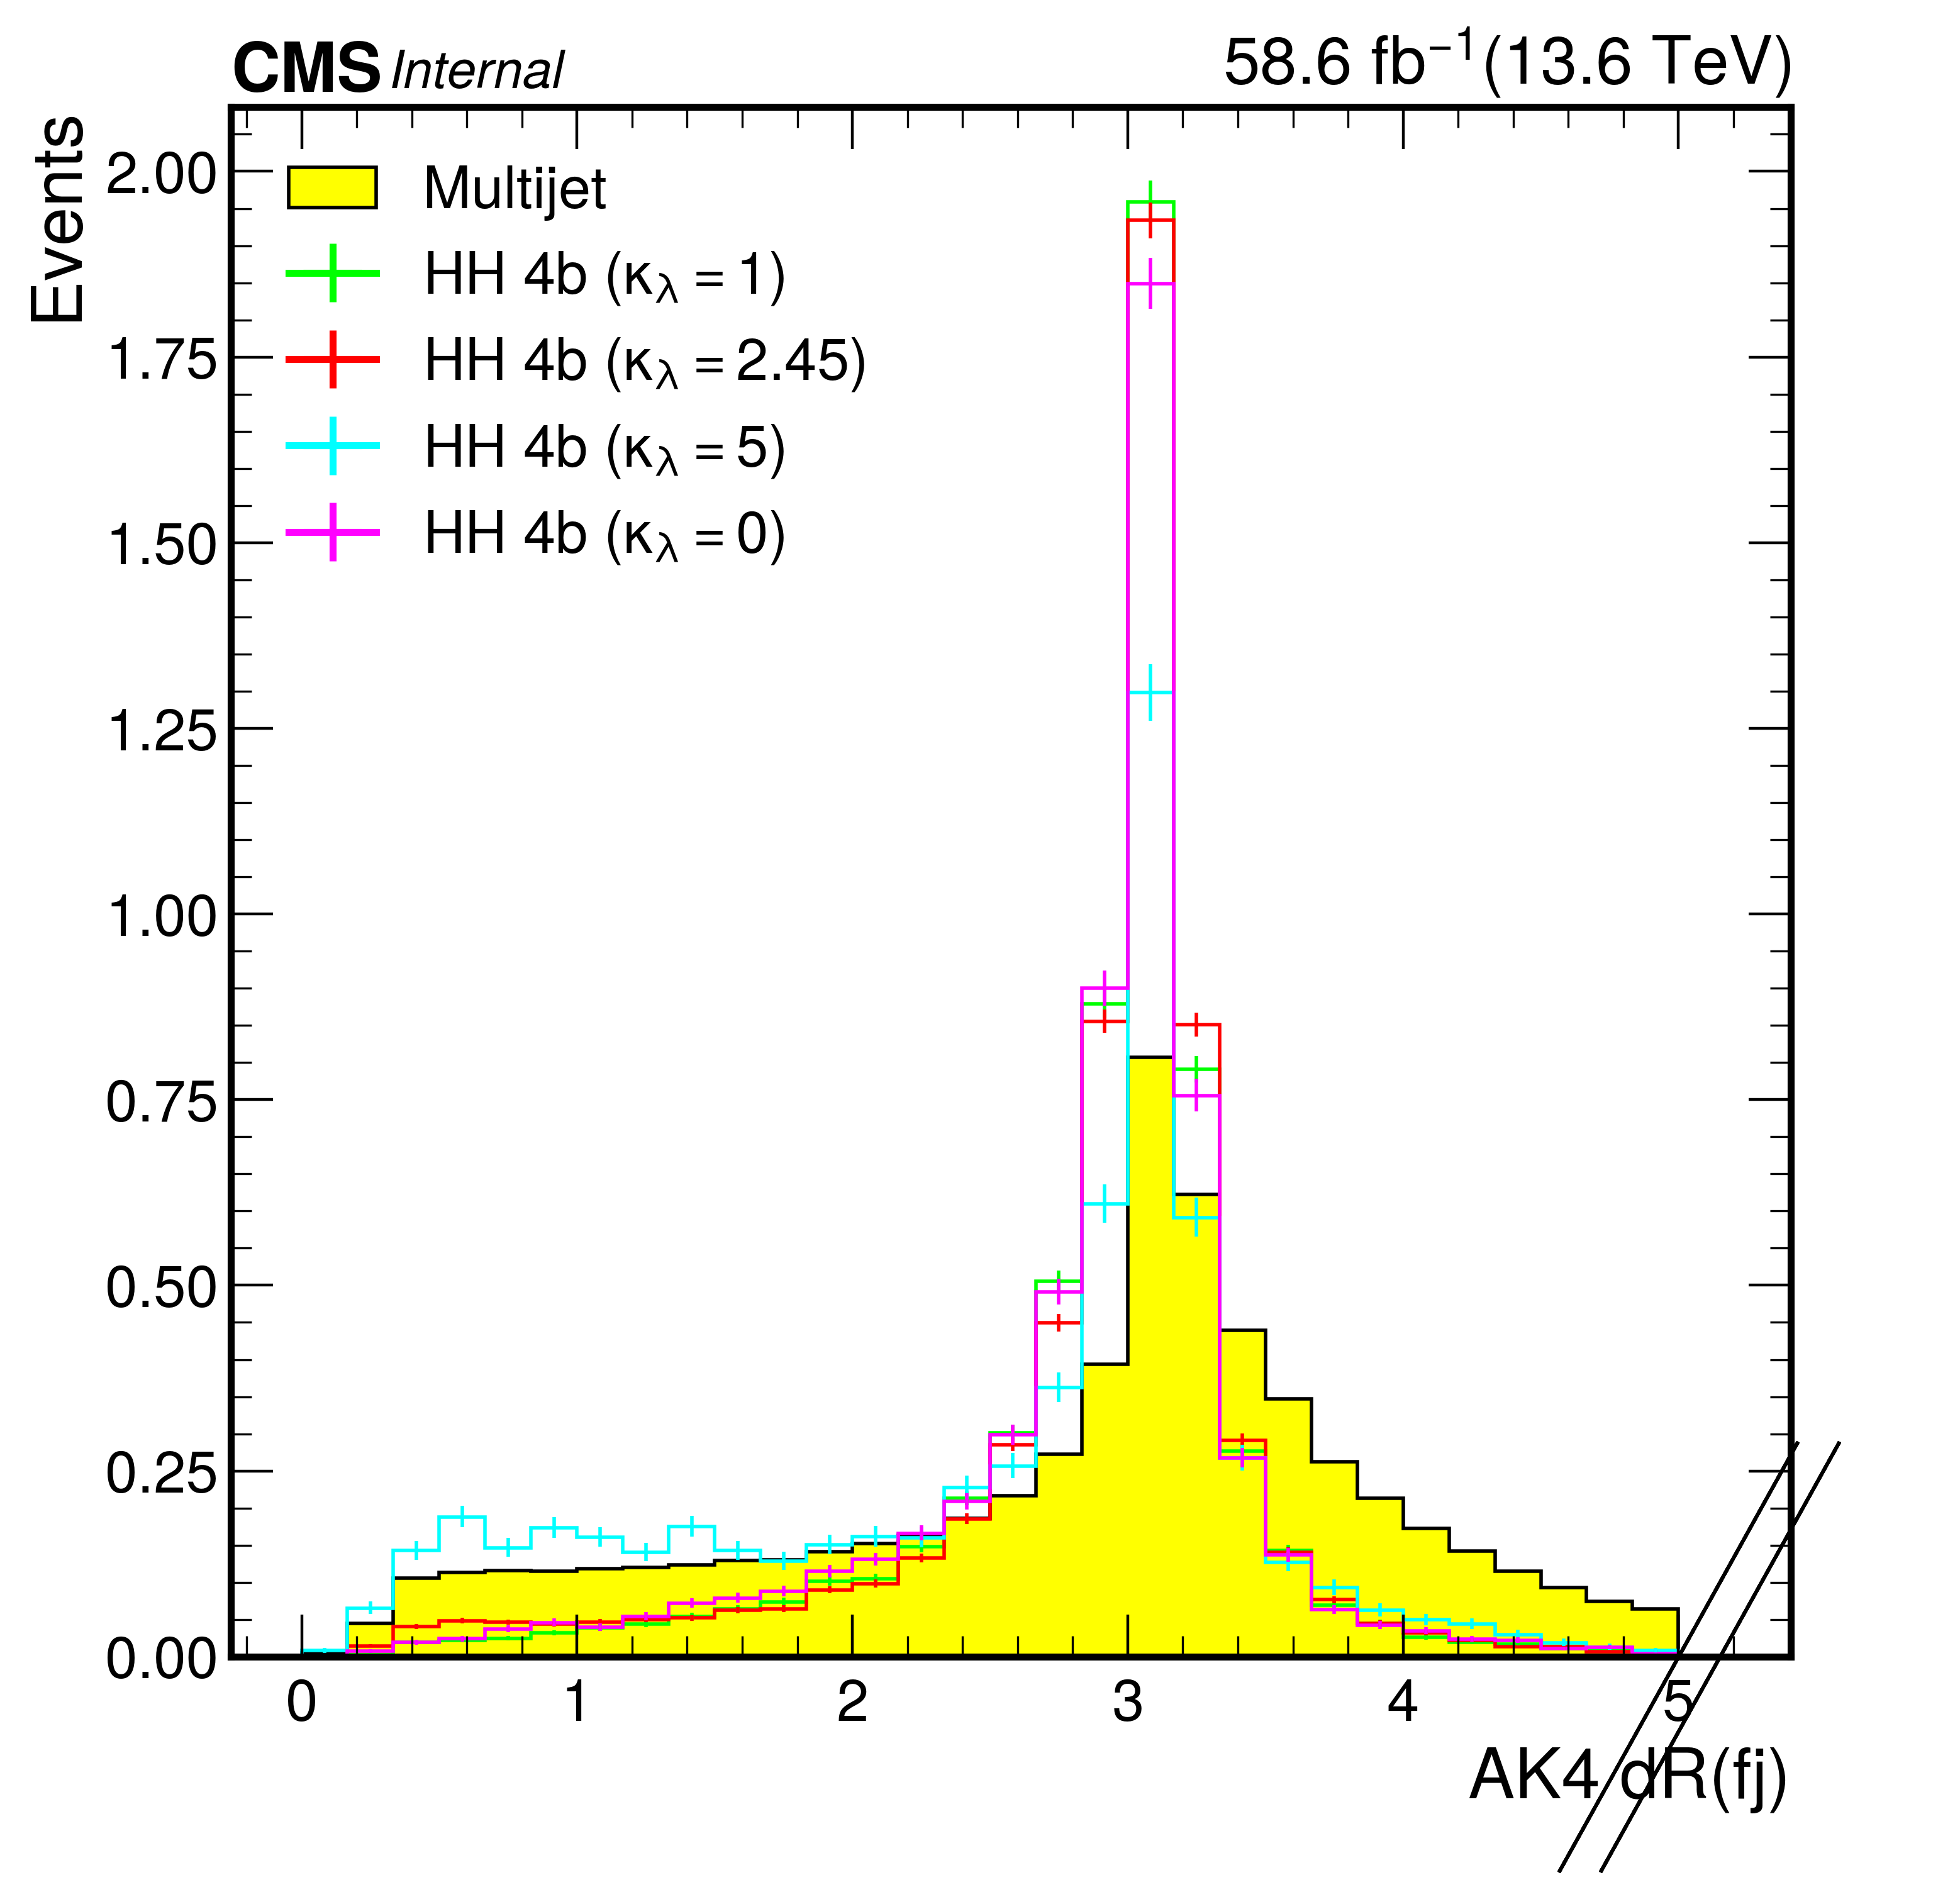

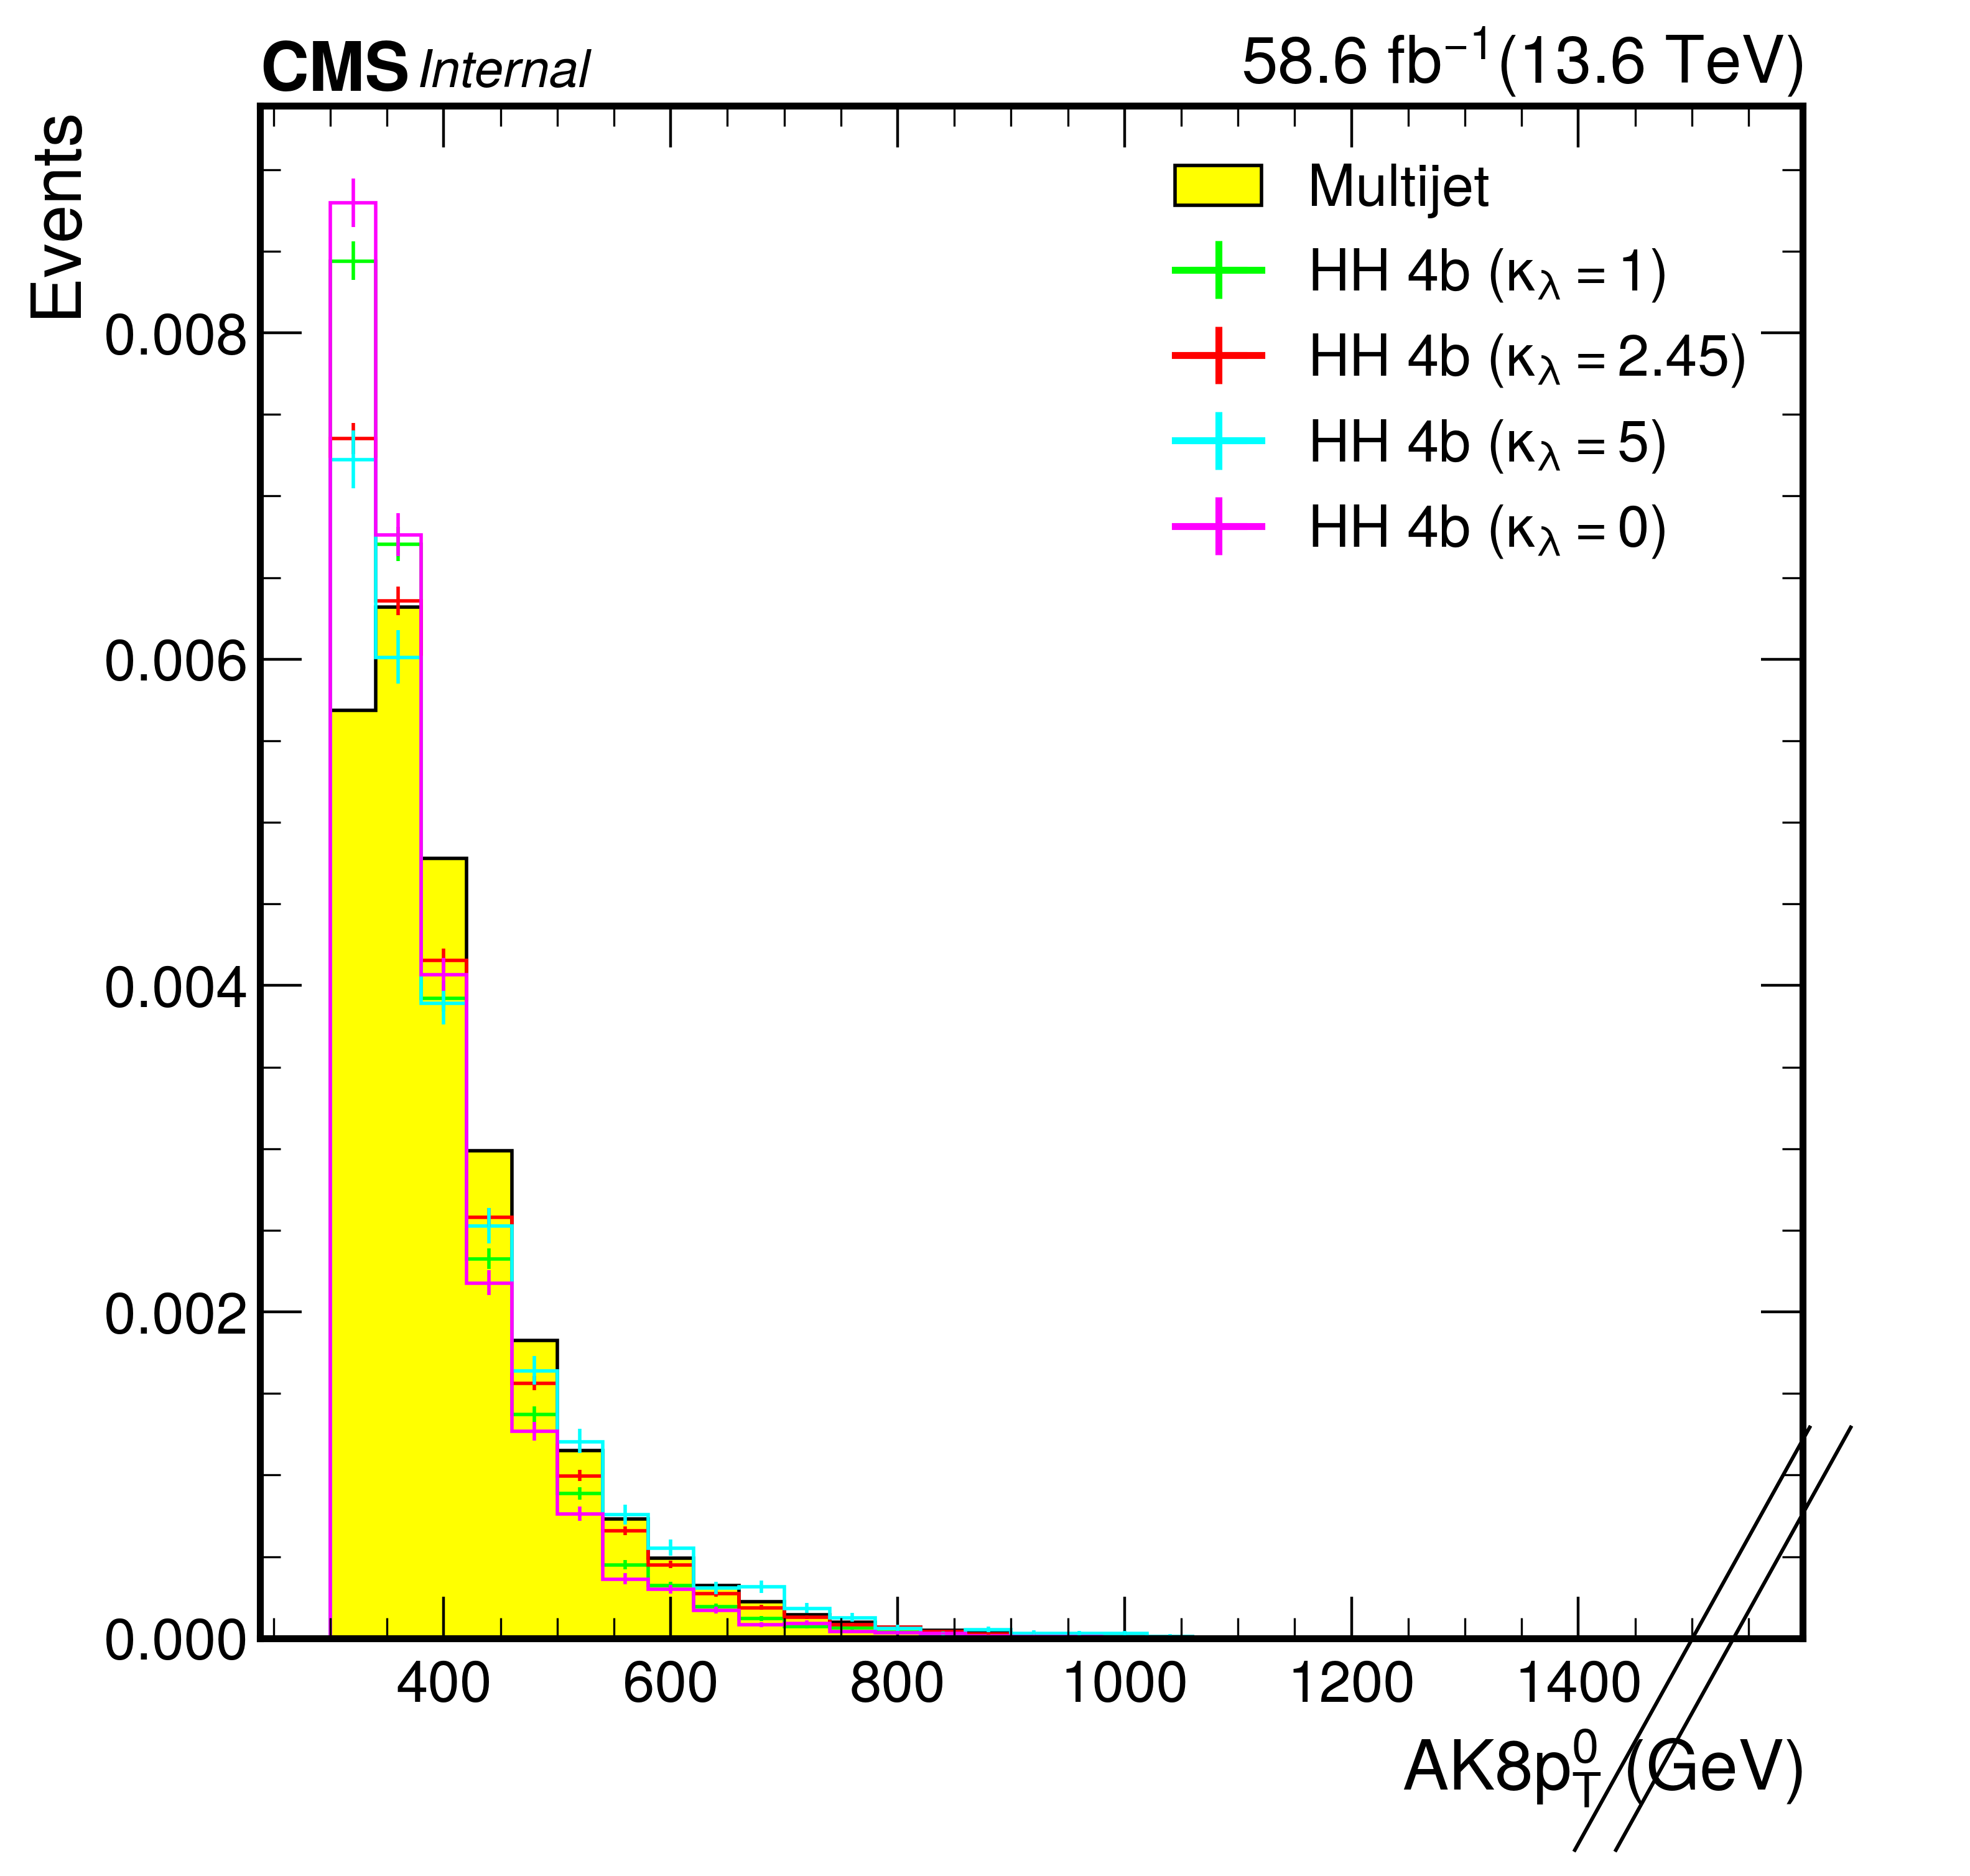

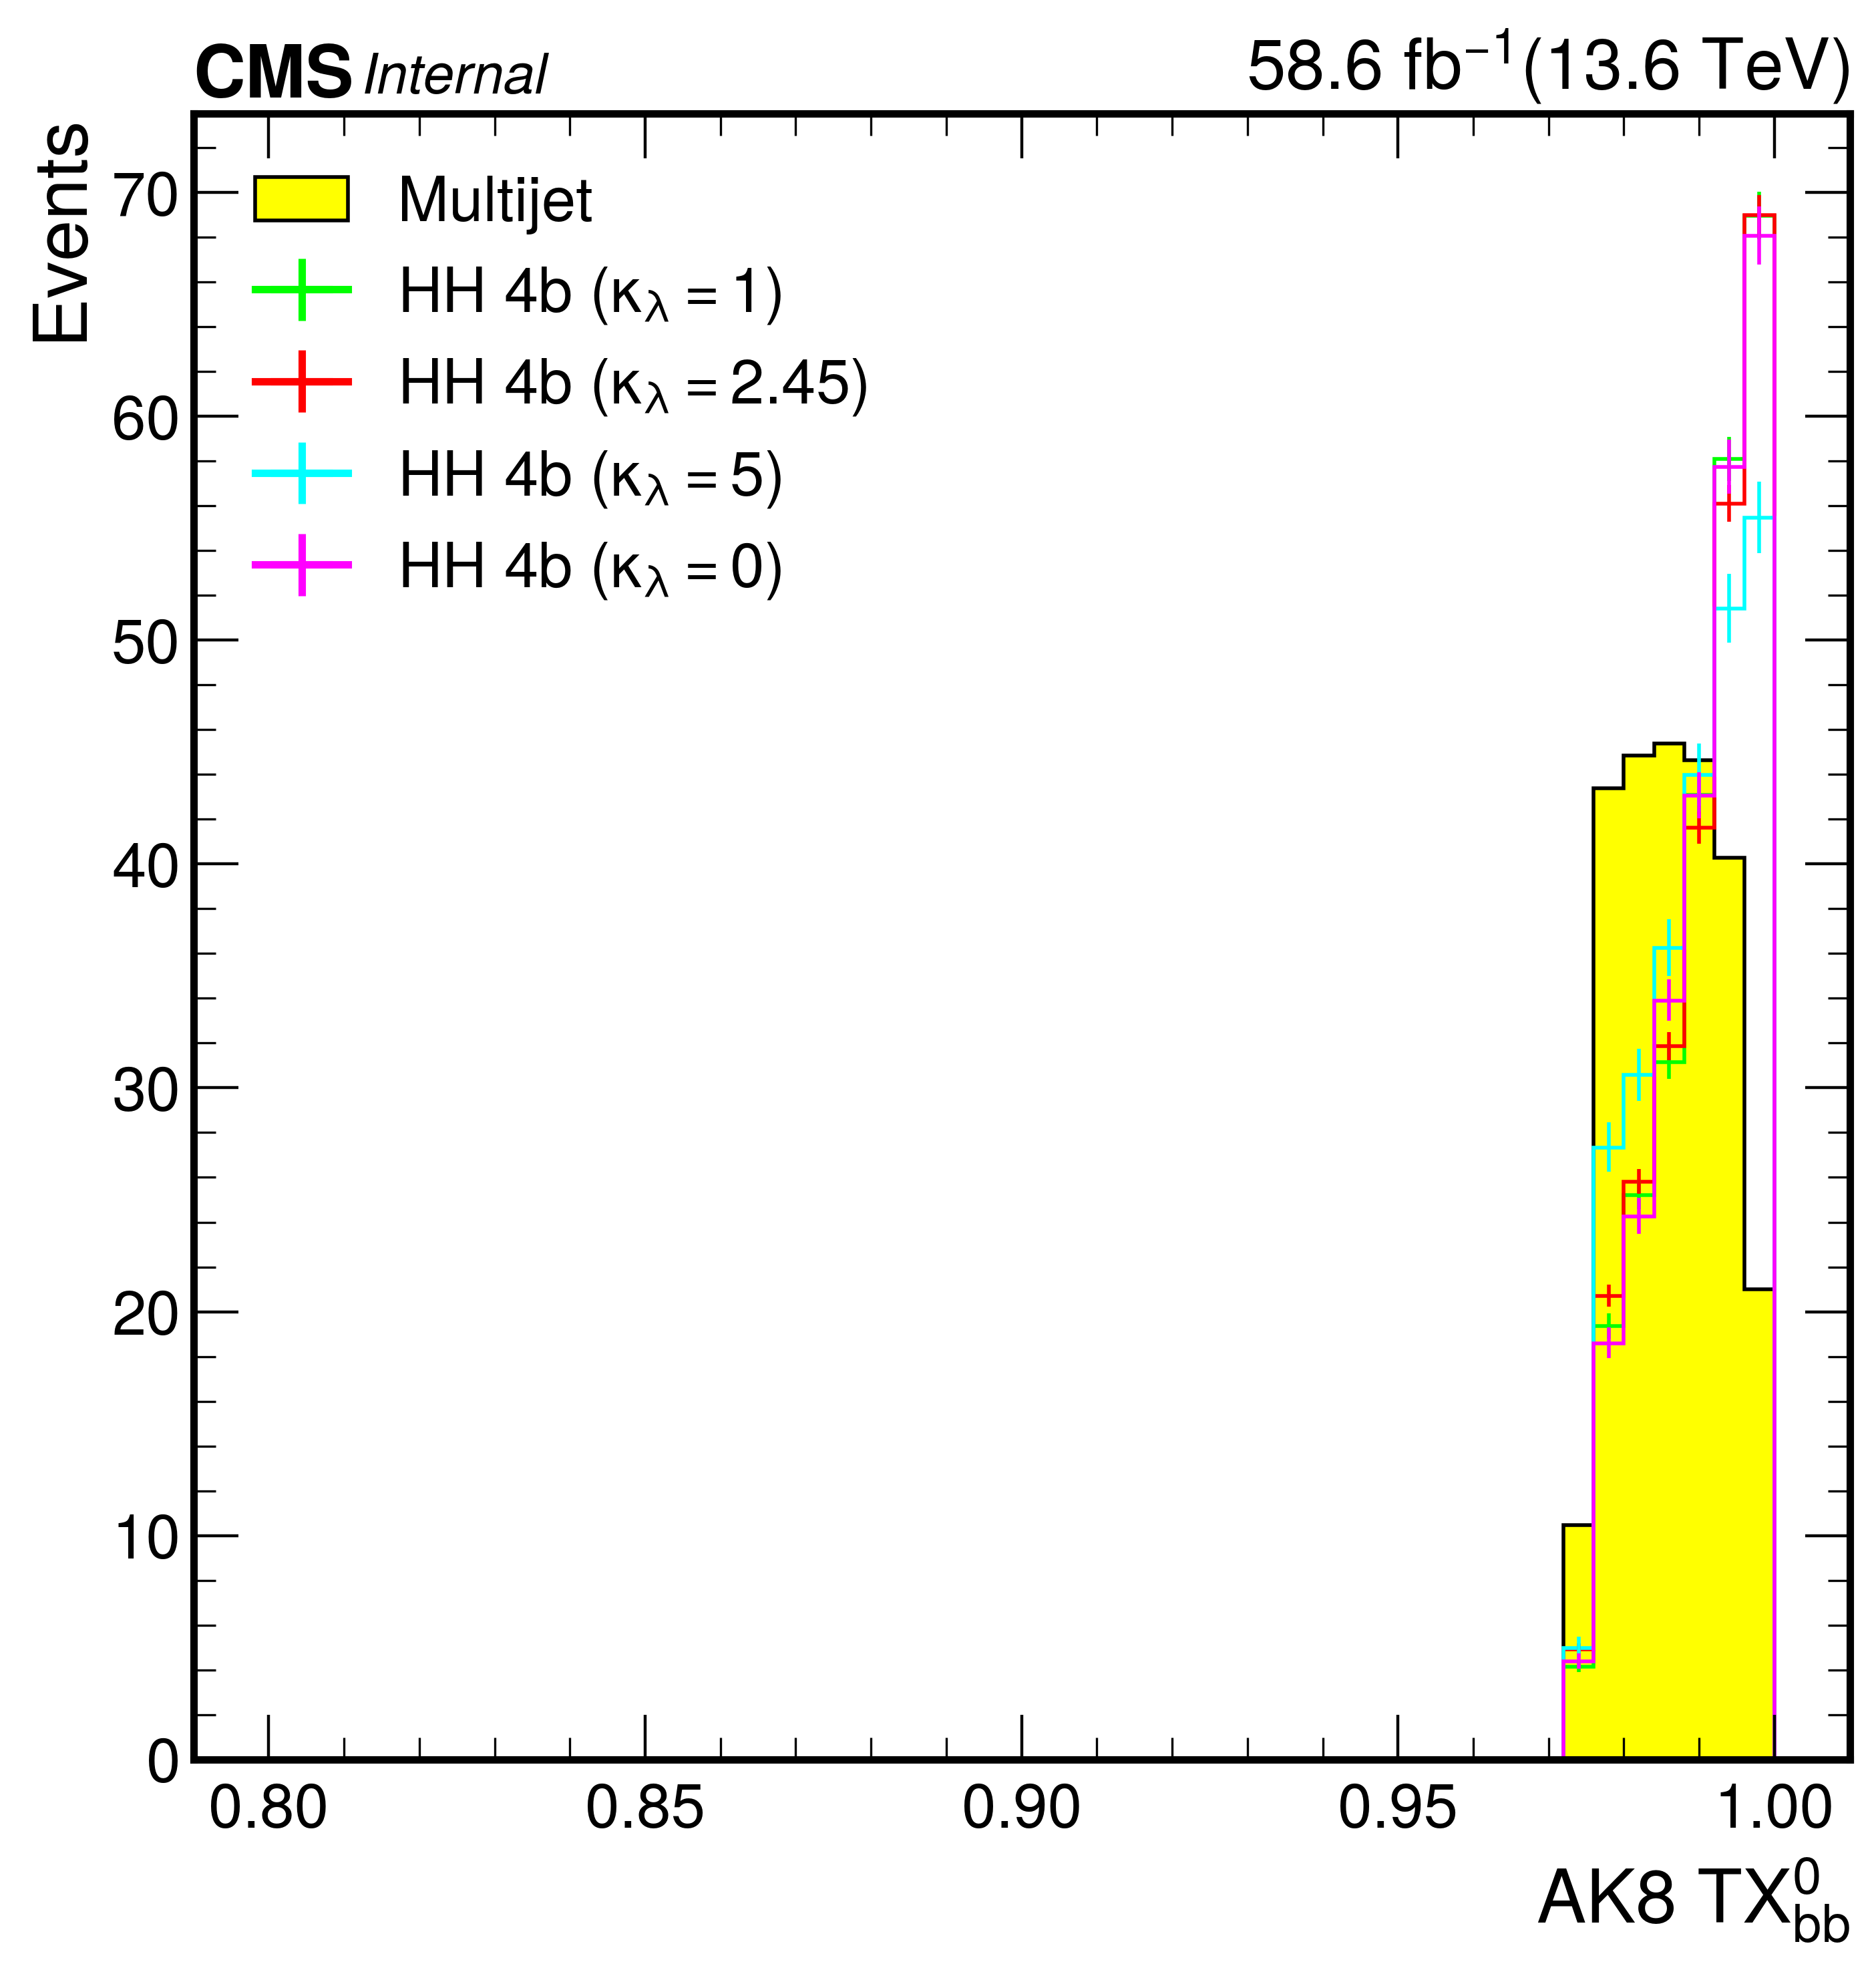

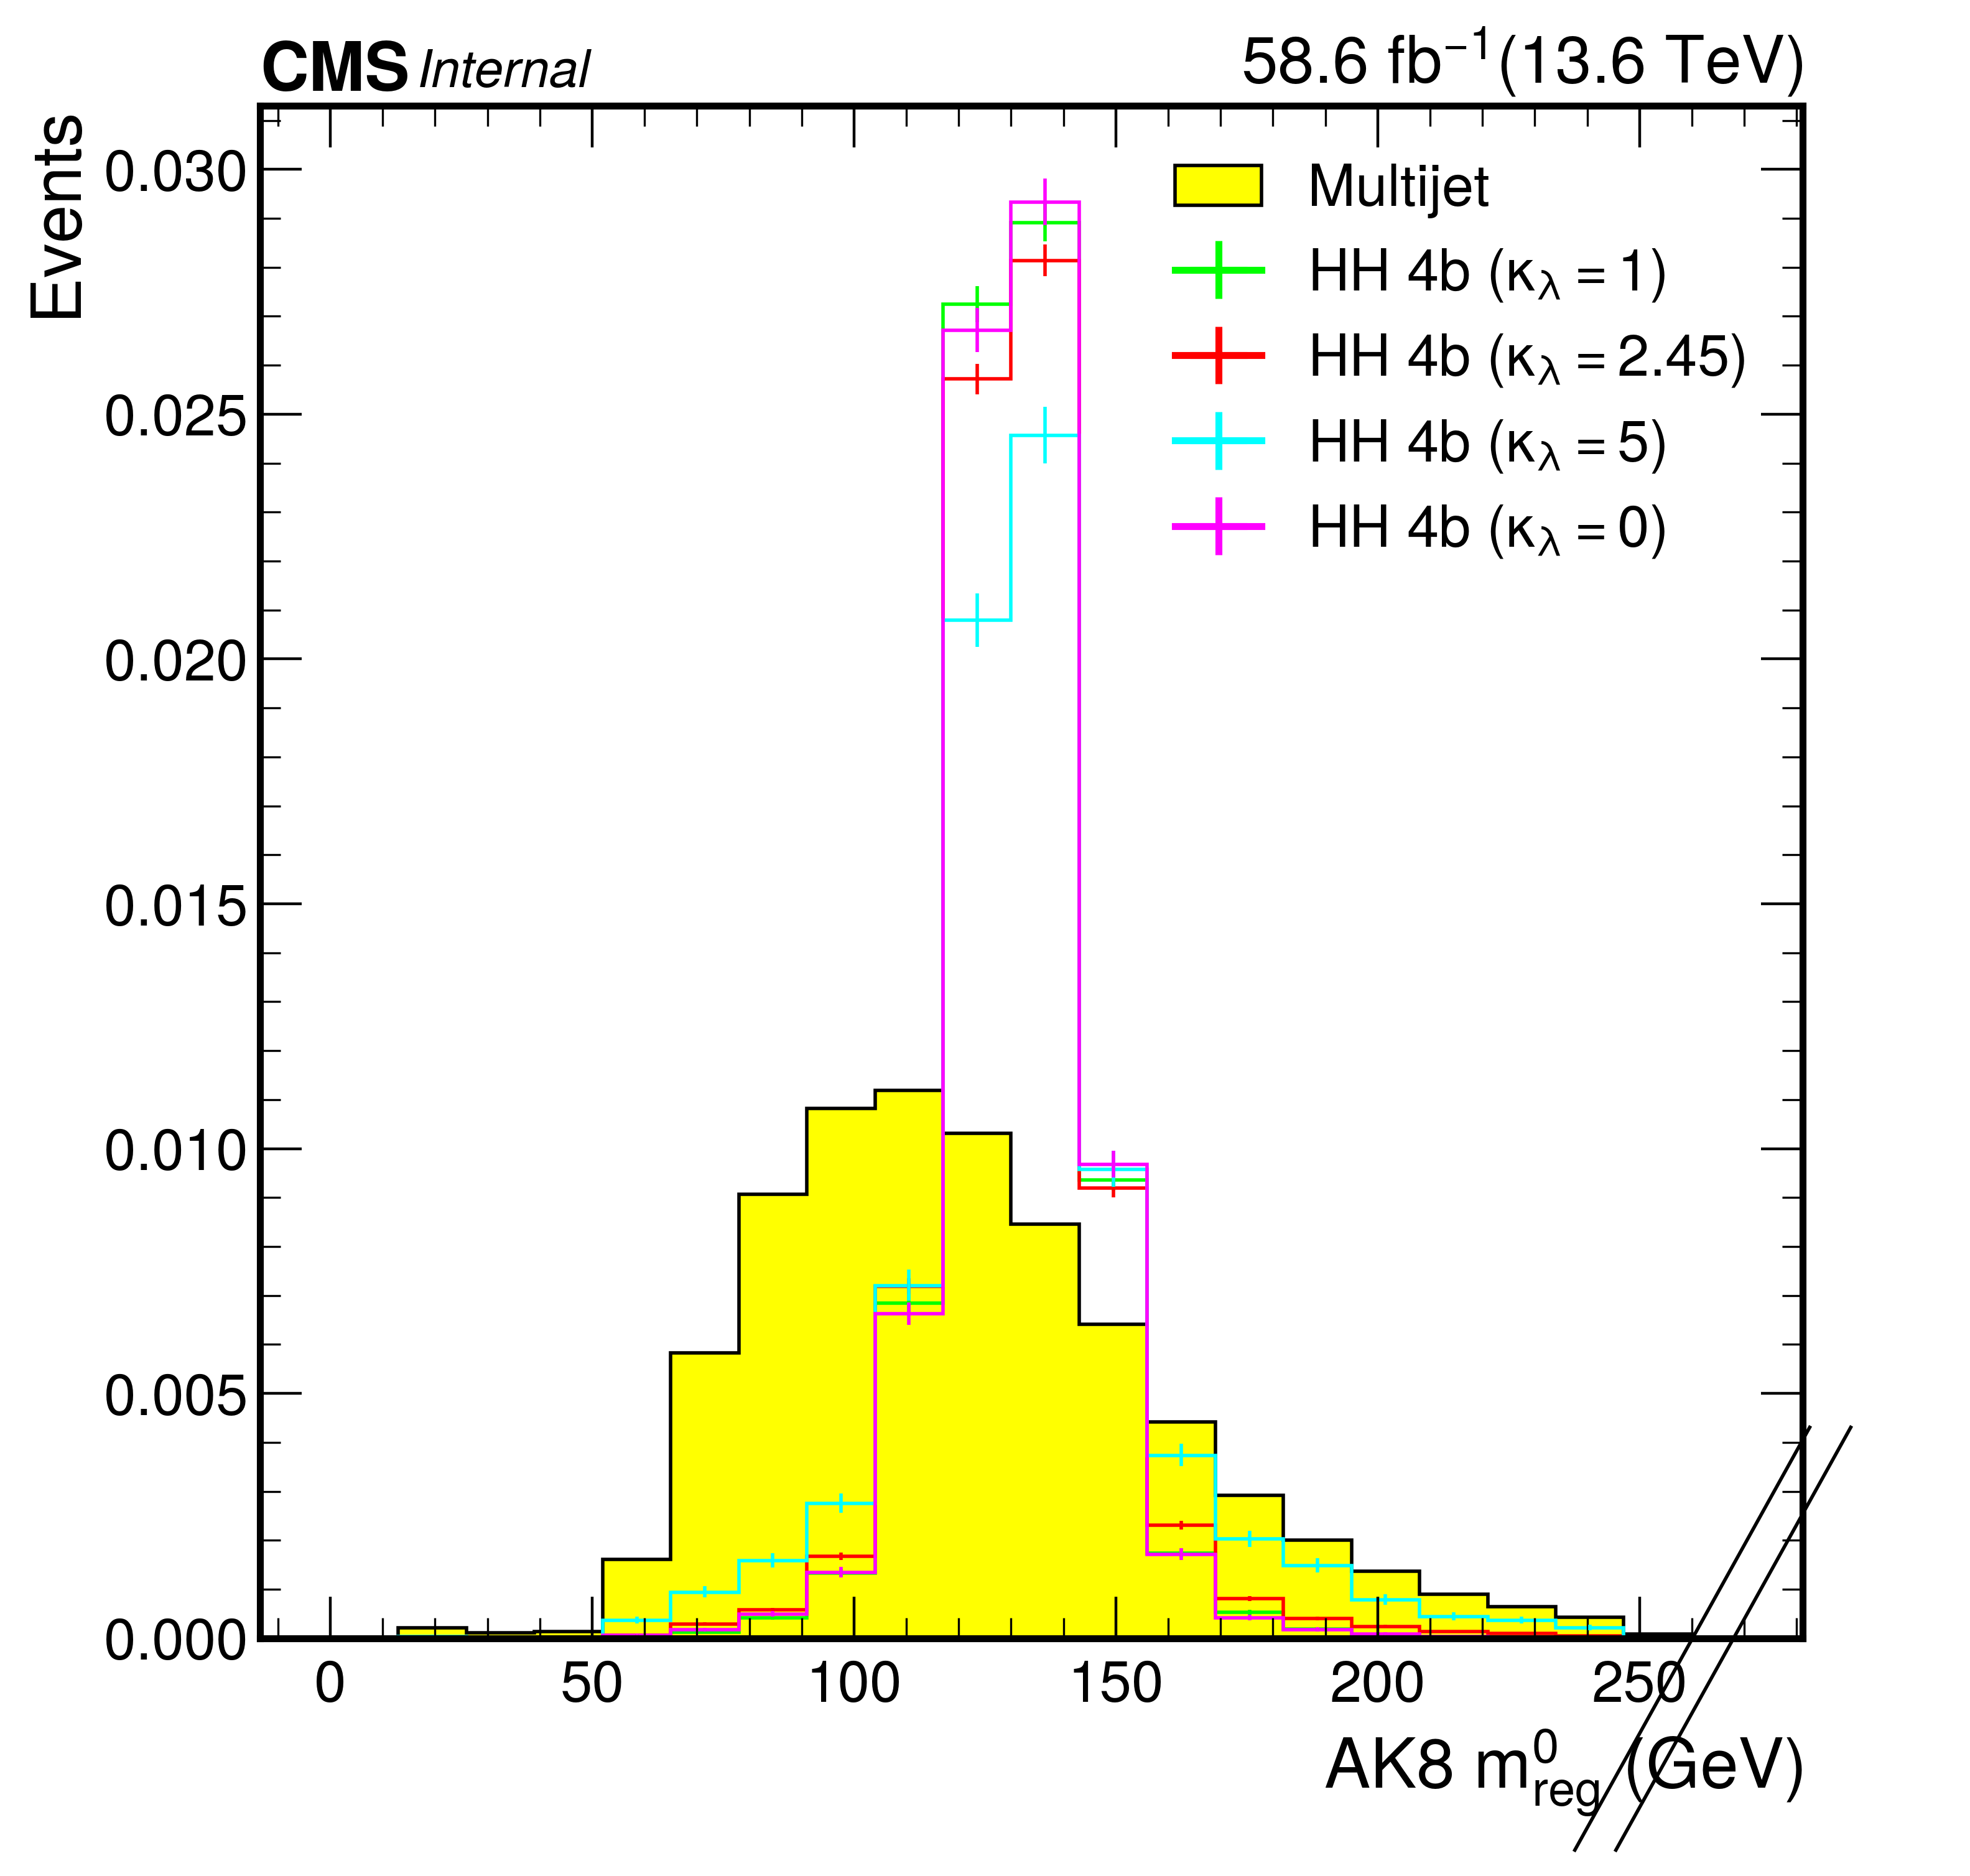

In [65]:
# make a stacked plot
from plotting import plot_hists

plot_hists(
    year,
    hists,
    vars_to_plot,
    58.6,
    add_data=False,
    # mult_factor=100,
    # logy=True,
    mult_factor = 1,
    logy = False,
    density = True,
    stack = True,
    bbox_to_anchor=None
)